Number of training examples: 240
Number of test examples: 60
Epoch 1/20
30/30 [==============================] - 31s 582ms/step - loss: 0.2721 - mean_iou: 0.4736 - val_loss: 0.1818 - val_mean_iou: 0.4756
Epoch 2/20
30/30 [==============================] - 13s 449ms/step - loss: 0.1823 - mean_iou: 0.4748 - val_loss: 0.1818 - val_mean_iou: 0.4756
Epoch 3/20
30/30 [==============================] - 14s 453ms/step - loss: 0.1821 - mean_iou: 0.4748 - val_loss: 0.1878 - val_mean_iou: 0.4756
Epoch 4/20
30/30 [==============================] - 14s 459ms/step - loss: 0.1802 - mean_iou: 0.4748 - val_loss: 0.1811 - val_mean_iou: 0.4756
Epoch 5/20
30/30 [==============================] - 14s 464ms/step - loss: 0.1805 - mean_iou: 0.4748 - val_loss: 0.1859 - val_mean_iou: 0.4756
Epoch 6/20
30/30 [==============================] - 14s 465ms/step - loss: 0.1805 - mean_iou: 0.4748 - val_loss: 0.1863 - val_mean_iou: 0.4756
Epoch 7/20
30/30 [==============================] - 14s 463ms/step - loss: 0.1749

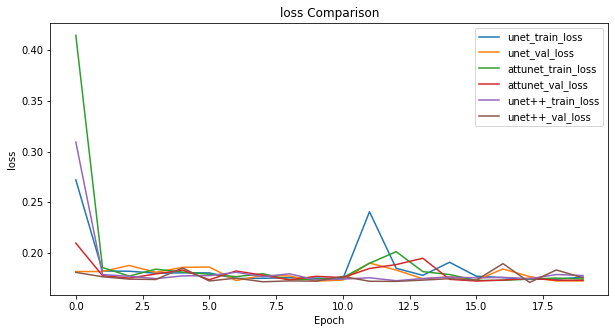

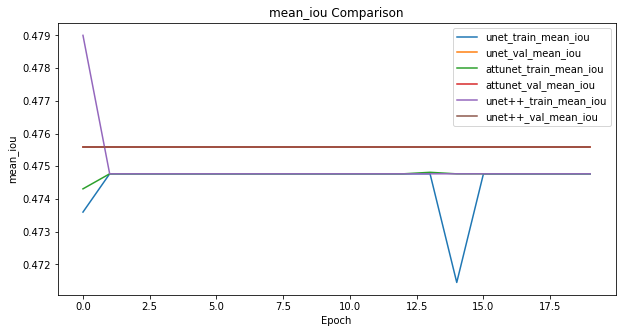

Final Test MeanIoU:
U-Net: 0.4756
Attention U-Net: 0.4756
U-Net++: 0.4756


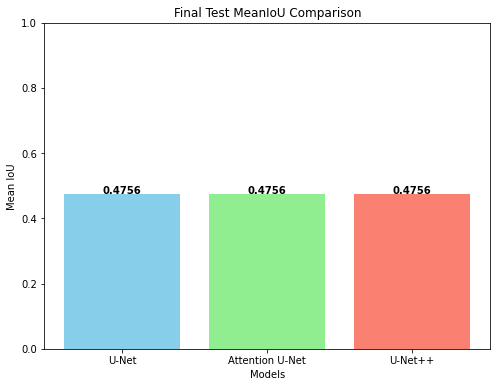

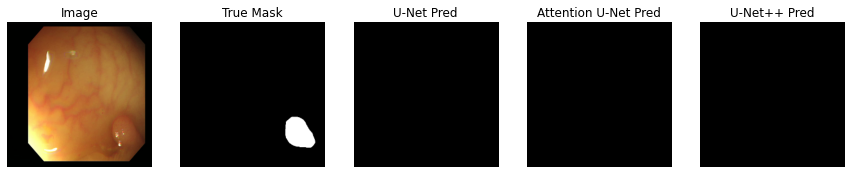

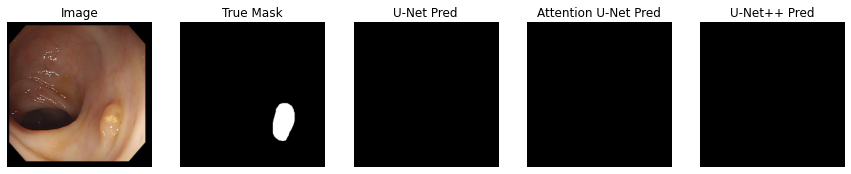

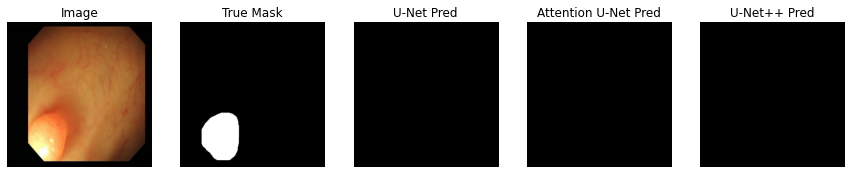

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# -----------------------------------------------------
# 데이터 경로 설정
# -----------------------------------------------------
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

# -----------------------------------------------------
# 이미지 및 라벨 파일 리스트 생성
# -----------------------------------------------------
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

# train/test split
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = train_test_split(
    x_train_filenames, y_train_filenames, test_size=0.2, random_state=42
)

num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

# -----------------------------------------------------
# 하이퍼파라미터 설정
# -----------------------------------------------------
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8
EPOCHS = 20
AUTOTUNE = tf.data.experimental.AUTOTUNE

# -----------------------------------------------------
# 함수 정의: 이미지, 라벨 로딩 및 전처리
# -----------------------------------------------------
def _load_image_and_mask(img_path, mask_path):
    # 이미지 로드 (3채널)
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0

    # 마스크 로드 (원본 채널 유지)
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_image(mask, channels=0, expand_animations=False)
    # 만약 원본이 3채널이라면 그 중 첫 채널만 사용하여 1채널 마스크로 만듭니다.
    mask = mask[..., :1]
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    mask = tf.cast(mask, tf.float32) / 255.0

    return img, mask

def _augment_image_and_mask(img, mask):
    if tf.random.uniform([]) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform([]) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)
    return img, mask

def _load_train_dataset(img_path, mask_path):
    img, mask = _load_image_and_mask(img_path, mask_path)
    img, mask = _augment_image_and_mask(img, mask)
    return img, mask

def _load_test_dataset(img_path, mask_path):
    img, mask = _load_image_and_mask(img_path, mask_path)
    return img, mask

# -----------------------------------------------------
# tf.data.Dataset 생성
# -----------------------------------------------------
train_ds = tf.data.Dataset.from_tensor_slices((x_train_filenames, y_train_filenames))
train_ds = train_ds.shuffle(buffer_size=num_train_examples, reshuffle_each_iteration=True)
train_ds = train_ds.map(_load_train_dataset, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test_filenames, y_test_filenames))
test_ds = test_ds.map(_load_test_dataset, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# -----------------------------------------------------
# 모델 정의
# -----------------------------------------------------
def unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D()(c3)

    c4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


def attention_block(g, x, filters):
    theta_x = tf.keras.layers.Conv2D(filters, 2, strides=2, padding='same')(x)
    phi_g = tf.keras.layers.Conv2D(filters, 1, padding='same')(g)
    concat_xg = tf.keras.layers.add([phi_g, theta_x])
    act_xg = tf.keras.layers.Activation('relu')(concat_xg)
    psi = tf.keras.layers.Conv2D(1, 1, padding='same')(act_xg)
    psi = tf.keras.layers.Activation('sigmoid')(psi)
    psi = tf.keras.layers.UpSampling2D(size=(2,2))(psi)
    return tf.keras.layers.multiply([x, psi])

def attention_unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D()(c3)

    c4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D()(c4)

    c5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder with Attention
    g4 = tf.keras.layers.Conv2D(512, 1, padding='same')(c5)
    att4 = attention_block(g4, c4, 512)
    u6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, att4])
    c6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    g3 = tf.keras.layers.Conv2D(256, 1, padding='same')(c6)
    att3 = attention_block(g3, c3, 256)
    u7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, att3])
    c7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    g2 = tf.keras.layers.Conv2D(128, 1, padding='same')(c7)
    att2 = attention_block(g2, c2, 128)
    u8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, att2])
    c8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    g1 = tf.keras.layers.Conv2D(64, 1, padding='same')(c8)
    att1 = attention_block(g1, c1, 64)
    u9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, att1])
    c9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

def unet_pp_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D()(c3)

    c4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D()(c4)

    c5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # U-Net++ 스타일: 기존 U-Net보다 skip 연결을 다양화
    # 여기서는 단순 예시로 중간 수준 피쳐를 추가적으로 활용
    u6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    c4_1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    u6 = tf.keras.layers.concatenate([u6, c4, c4_1])
    c6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    c3_1 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    u7 = tf.keras.layers.concatenate([u7, c3, c3_1])
    c7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    c2_1 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    u8 = tf.keras.layers.concatenate([u8, c2, c2_1])
    c8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    c1_1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    u9 = tf.keras.layers.concatenate([u9, c1, c1_1])
    c9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# -----------------------------------------------------
# Mean IoU Metric 정의
# -----------------------------------------------------
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=2, name='mean_iou', dtype=None):
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.int32)
        return super().update_state(tf.cast(y_true, tf.int32), y_pred, sample_weight)

# -----------------------------------------------------
# 모델 학습 (U-Net, Attention U-Net, U-Net++)
# -----------------------------------------------------
model_unet = unet_model()
model_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
history_unet = model_unet.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

model_attunet = attention_unet_model()
model_attunet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
history_attunet = model_attunet.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

model_unetpp = unet_pp_model()
model_unetpp.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
history_unetpp = model_unetpp.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

# -----------------------------------------------------
# 학습 결과 비교 시각화
# -----------------------------------------------------
def plot_metrics(histories, metric='mean_iou'):
    plt.figure(figsize=(10,5))
    for name, hist in histories.items():
        plt.plot(hist.history[metric], label=f'{name}_train_{metric}')
        plt.plot(hist.history['val_' + metric], label=f'{name}_val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'{metric} Comparison')
    plt.show()

plot_metrics({'unet': history_unet, 'attunet': history_attunet, 'unet++': history_unetpp}, metric='loss')
plot_metrics({'unet': history_unet, 'attunet': history_attunet, 'unet++': history_unetpp}, metric='mean_iou')

# -----------------------------------------------------
# 추가적인 성능 비교 및 시각화 코드
# -----------------------------------------------------
# 3가지 모델에 대한 최종 성능 평가
test_loss_unet, test_miou_unet = model_unet.evaluate(test_ds, verbose=0)
test_loss_attunet, test_miou_attunet = model_attunet.evaluate(test_ds, verbose=0)
test_loss_unetpp, test_miou_unetpp = model_unetpp.evaluate(test_ds, verbose=0)

print("Final Test MeanIoU:")
print("U-Net: {:.4f}".format(test_miou_unet))
print("Attention U-Net: {:.4f}".format(test_miou_attunet))
print("U-Net++: {:.4f}".format(test_miou_unetpp))

# 바 그래프로 최종 MeanIoU 비교
models = ['U-Net', 'Attention U-Net', 'U-Net++']
final_miou = [test_miou_unet, test_miou_attunet, test_miou_unetpp]

plt.figure(figsize=(8,6))
plt.bar(models, final_miou, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Models')
plt.ylabel('Mean IoU')
plt.title('Final Test MeanIoU Comparison')
for i, v in enumerate(final_miou):
    plt.text(i, v+0.001, f"{v:.4f}", ha='center', fontweight='bold')
plt.ylim([0, 1])
plt.show()

# -----------------------------------------------------
# 동일한 테스트 이미지를 모든 모델로 예측하여 비교
# -----------------------------------------------------
def display_model_comparisons(models, dataset, num=3):
    for images, masks in dataset.take(1):
        # 각 모델별 예측
        predictions = {}
        for name, model in models.items():
            preds = model.predict(images)
            predictions[name] = preds
        
        for i in range(num):
            plt.figure(figsize=(15, 5))
            plt.subplot(1, len(models)+2, 1) # 원본 이미지
            plt.title("Image")
            plt.imshow(images[i])
            plt.axis('off')

            plt.subplot(1, len(models)+2, 2) # 정답 마스크
            plt.title("True Mask")
            plt.imshow(masks[i,:,:,0], cmap='gray')
            plt.axis('off')

            col_idx = 3
            for name, preds in predictions.items():
                plt.subplot(1, len(models)+2, col_idx)
                plt.title(f"{name} Pred")
                pred_mask = preds[i,:,:,0] > 0.5
                plt.imshow(pred_mask, cmap='gray')
                plt.axis('off')
                col_idx += 1

            plt.show()

model_dict = {
    'U-Net': model_unet,
    'Attention U-Net': model_attunet,
    'U-Net++': model_unetpp
}

display_model_comparisons(model_dict, test_ds, num=3)
